In [1]:
import os

# Check if the environment is activated
if "CONDA_DEFAULT_ENV" in os.environ:
    print(f"Environment '{os.environ['CONDA_DEFAULT_ENV']}' is activated.")
else:
    print("No specific environment is activated.")

Environment 'research' is activated.


In [2]:
import numpy as np
import pandas as pd
from IPython.display import display

np.random.seed(42)

In [3]:
# Load the Boston dataset
dataset = "boston"
raw_df = pd.read_csv("data/boston.csv")
target = ["MEDV"]
features = raw_df.columns.drop(target)
target, features

(['MEDV'],
 Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
        'PTRATIO', 'B', 'LSTAT'],
       dtype='object'))

In [4]:
# # Load the store sales dataset
# dataset = "store_sales"
# excel_file = pd.ExcelFile("data/store_sales.xlsx")
# sheet_names = excel_file.sheet_names

# # Read the data
# raw_df = pd.read_excel(excel_file, sheet_name=sheet_names[2])  # 2, 9
# iri_key_counts = raw_df["IRI_KEY"].value_counts()
# iri_keys = iri_key_counts[iri_key_counts > 300].index


# target = ["Total.Volume"]
# features = ["F", "D", "Unit.Price"]

# raw_df = raw_df[raw_df["IRI_KEY"] == iri_keys[0]]

# sheet_names, iri_keys

In [5]:
# # Load the California housing dataset
# from sklearn.datasets import fetch_california_housing

# dataset = "california"
# housing = fetch_california_housing()
# target = housing.target_names
# features = housing.feature_names
# raw_df = pd.concat(
#     [
#         pd.DataFrame(housing.data, columns=housing.feature_names),
#         pd.DataFrame(housing.target, columns=housing.target_names),
#     ],
#     axis=1,
# )
# target, features

In [6]:
# # Load the soybean dataset
# dataset = "soybean"
# raw_df = pd.read_excel("data/soybean.xlsx")
# # X = raw_df.values[:-1, [5, 6, 15, 16, 17, 26,
# #                         34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]  # 9 check yield 12 rm band
# # y = raw_df.values[:-1, 11]
# X = raw_df.iloc[:-1, [5, 6, 15, 16, 17, 26,
#                   34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]
# y = raw_df.iloc[:-1, [11]]
# X.shape, y.shape

In [7]:
# # Load LengthOfStay
# dataset = "LengthOfStay"
# raw_df = pd.read_csv("data/LengthOfStay.csv")
# raw_df = raw_df.drop(columns=["eid", "vdate", "discharged"])
# target = ["lengthofstay"]
# features = raw_df.columns.drop(target)
# target, features

In [8]:
# # Load HospitalStay
# dataset = "HospitalStay"
# raw_df = pd.read_csv("data/Healthcare_Investments_and_Hospital_Stay.csv")
# target = ["Hospital_Stay"]
# features = raw_df.columns.drop(target)
# target, features

In [9]:
X = raw_df[features]
y = raw_df[target]

display(f"Dataset: {dataset}", X.describe(), y.describe())

'Dataset: boston'

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


,MEDV
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [10]:
# # Remove Outliers
# def remove_outliers(df, threshold=3):
#     z_scores = np.abs((df - df.mean()) / df.std())
#     return df[(z_scores < threshold).all(axis=1)]
# filtered_train_data = train_data
# for col in train_data.columns:
#     value_counts = train_data[col].value_counts().sort(by="count")
#     valid = value_counts.filter(pl.col("count") > value_counts["count"].max()/len(value_counts))[col]
#     filtered_train_data = filtered_train_data.filter(pl.col(col).is_in(valid))
# display(filtered_train_data, filtered_train_data.describe())

In [11]:
# Plot data
import matplotlib.pyplot as plt
import seaborn as sns


def plot_data(X, y, cols=4):
    fig, axs = plt.subplots(
        (X.shape[1]+X.shape[1]*y.shape[1] + y.shape[1]+cols-1)//cols, cols, figsize=(20, 15))
    axs = axs.flatten()

    a = 0
    for i, col in enumerate(X.columns):
        data = X[col].to_numpy()
        ax = axs[a+i]
        sns.histplot(data, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.tick_params(axis="both", which="major")
        ax.tick_params(axis="both", which="minor")
    a += i + 1
    for i, col in enumerate(X.columns):
        data = X[col].to_numpy()
        for j, ycol in enumerate(y.columns):
            ax = axs[a+i+j*y.shape[1]]
            sns.scatterplot(x=data, y=y[ycol], ax=ax)
            ax.set_title(f"{col} vs {ycol}")
            ax.set_xlabel(col)
            ax.set_ylabel(ycol)
    a += i + 1
    for i, col in enumerate(y.columns):
        data = y[col].to_numpy()
        ax = axs[a+i]
        sns.histplot(data, kde=True, ax=ax)
        ax.set_title(col)
    a += i+1
    for j in range(a, len(axs)):
        fig.delaxes(axs[j])

    fig.tight_layout()
    plt.show()
    
# plot_data(X, y)

In [12]:
# Define search
from optuna.integration.sklearn import OptunaSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    TargetEncoder,
)

CATEGORICAL_PREPROCESSORS = {
    "drop": "drop",
    "ordinal": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    "one_hot": OneHotEncoder(
        handle_unknown="ignore", max_categories=20, sparse_output=False
    ),
    "target": TargetEncoder(target_type="continuous"),
}

SCALERS = {
    "identity": None,
    "standard": StandardScaler(),
    "minmax": MinMaxScaler(),
    "robust": RobustScaler(),
    "quantile": QuantileTransformer(),
}

search_params = {
    "cv": 5,
    "n_jobs": -1,  # -1,
    "n_trials": 10, # 1
    # "n_trials": None,
    "random_state": 42,
    "return_train_score": True,
    "scoring": "neg_mean_squared_error",  # r2
    # "timeout": 10,
    # "timeout": None,
    "verbose": 1,
}


def search(
    model,
    param_grid={},
    categorical_preprocessor="drop",
    scaler="identity",
    search_params=search_params,
):
    search_params = search_params.copy()
    # search_params["n_trials"] = int(4**len(param_grid))

    numerical_features = X.select_dtypes(include=["number"]).columns
    categorical_features = X.select_dtypes(include=["object", "category"]).columns
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            (
                "categorical",
                CATEGORICAL_PREPROCESSORS[categorical_preprocessor],
                categorical_features,
            ),
        ]
    )

    return OptunaSearchCV(
        Pipeline(
            [
                ("categorical_preprocessor", preprocessor),
                ("scaler", SCALERS[scaler]),
                ("model", model),
            ]
        ),
        {f"model__{k}": v for k, v in param_grid.items()},
        **search_params,
    )

In [13]:
# Define search grids
from optuna.distributions import (
    CategoricalDistribution,
    FloatDistribution,
    IntDistribution,
)

mlp_sk_param_grid = {
    "learning_rate_init": FloatDistribution(1e-3, 1e-1, log=True),
    "max_iter": IntDistribution(400, 400, log=True),
    "early_stopping": CategoricalDistribution([False]),
}

# fonn1_sk_param_grid = {
#     "learning_rate_init": FloatDistribution(1e-2, 1e-1, log=True),
#     "max_iter": IntDistribution(400, 400, log=True),
# }

# fonn2_sk_param_grid = {
#     "learning_rate_init": FloatDistribution(1e-2, 1e-1, log=True),
#     "max_iter": IntDistribution(400, 400, log=True),
# }

mlp_TrANN_param_grid = {
    "learning_rate": FloatDistribution(1e-2, 1e-1, log=True),
    "max_iter": IntDistribution(400, 400, log=True),
}

In [ ]:
# from models import MLP, FONN1, FONN2, TREENN1, TREENN2
from models_sklearn import (
    Tree,
    Ensemble,
    MLP as MLP_sk,
    FONN1 as FONN1_sk,
    FONN2 as FONN2_sk,
    TREENN1 as TREENN1_sk,
    TREENN2 as TREENN2_sk,
)
from models_TrANN import (
    FONN1 as FONN1_TrANN,
    FONN2 as FONN2_TrANN,
    FONN3 as FONN3_TrANN,
    TREENN1 as TREENN1_TrANN,
    TREENN2 as TREENN2_TrANN,
    TREENN3 as TREENN3_TrANN,
)

models = {}

num_trees_input = 5
num_trees_hidden = 5
hidden_nodes = [10]
# hidden_nodes = [5, 10]

scalers = ["standard"]
categorical_preprocessor = ["target"]

models["Tree"] = search(Tree())
for hn in hidden_nodes:
    models[f"Ensemble_sk {hn}"] = search(Ensemble(hn))
    models[f"MLP_sk {hn}"] = search(MLP_sk(hn), mlp_sk_param_grid)
    models[f"FONN1_sk {num_trees_input} {hn}"] = search(
        FONN1_sk(num_trees_input, num_trees_input + hn), mlp_sk_param_grid
    )
    models[f"FONN2_sk {num_trees_hidden} {hn}"] = search(
        FONN2_sk(hn, num_trees_hidden + hn), mlp_sk_param_grid
    )
for hn in hidden_nodes:
    for c in categorical_preprocessor:
        for s in scalers:
            models[f"MLP_sk_{c}_{s} {hn}"] = search(MLP_sk(hn), mlp_sk_param_grid, c, s)
            models[f"FONN1_sk_{c}_{s} {num_trees_input} {hn}"] = search(
                FONN1_sk(num_trees_input, num_trees_input + hn),
                mlp_sk_param_grid,
                c,
                s,
            )
            models[f"FONN2_sk_{c}_{s} {num_trees_hidden} {hn}"] = search(
                FONN2_sk(hn, num_trees_hidden + hn), mlp_sk_param_grid, c, s
            )

input_dim = X.shape[1]
output_dim = 1

for hn in hidden_nodes:
    models[f"FONN1_TrANN {num_trees_input} {hn}"] = search(
        FONN1_TrANN(input_dim, hn, output_dim, num_trees_input), mlp_TrANN_param_grid
    )
    models[f"FONN2_TrANN {num_trees_hidden} {hn}"] = search(
        FONN2_TrANN(input_dim, hn, output_dim, num_trees_hidden), mlp_TrANN_param_grid
    )
    # models[f"FONN3_TrANN {num_trees_hidden} {hn}"] = search(
    #     FONN3_TrANN(input_dim, hn, output_dim, num_trees_hidden), mlp_TrANN_param_grid
    # )
    # models[f"TREENN1_TrANN {hn}"] = search(
    #     TREENN1_TrANN(input_dim, hn, output_dim, 1), mlp_TrANN_param_grid
    # )
    # models[f"TREENN2_TrANN {hn}"] = search(
    #     TREENN2_TrANN(input_dim, hn, output_dim, 1), mlp_TrANN_param_grid
    # )
    # models[f"TREENN2_TrANN {hn}"] = search(
    #     TREENN3_TrANN(input_dim, hn, output_dim, 1), mlp_TrANN_param_grid
    # )

display(models)

/home/ahteh/miniconda3/envs/research/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/tmp/ipykernel_3216003/4045429919.py:69: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(
/tmp/ipykernel_3216003/4045429919.py:69: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(
/tmp/ipykernel_3216003/4045429919.py:69: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(
/tmp/ipykernel_3216003/4045429919.py:69: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(
/tmp/ipykernel_3216003/4045429919.py:69

{'Tree': OptunaSearchCV(cv=5,
                estimator=Pipeline(steps=[('categorical_preprocessor',
                                           ColumnTransformer(transformers=[('numerical',
                                                                            'passthrough',
                                                                            Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
        'PTRATIO', 'B', 'LSTAT'],
       dtype='object')),
                                                                           ('categorical',
                                                                            'drop',
                                                                            Index([], dtype='object'))])),
                                          ('scaler', None), ('model', Tree())]),
                n_jobs=-1, param_distributions={}, random_state=42,
                return_train_score=True, scoring='neg_mean_squared_error',

In [15]:
import time

# Train and evaluate models
cv_results = {}
results = []

result_columns = [
    "model", "mean_fit_time", "mean_score_time", "mean_train_score", "mean_test_score"
]


def fit_model(name, model, X, y):
    print(f"Fitting {name}...")
    model.fit(X, y.to_numpy().ravel())
    result = model.cv_results_
    cv_results[name] = result
    return {
        "model": name,
        **{col: result[col][model.best_index_] for col in result}
    }


for name, model in models.items():
    results.append(fit_model(name, model, X, y))

raw_df = pd.DataFrame(results)
# results_df.set_index("model", inplace=True)
raw_df = raw_df[result_columns]
raw_df.to_csv(f"output/model_results_{dataset}_{time.strftime('%F_%T')}.csv", index=False)

[I 2025-01-22 20:21:13,994] A new study created in memory with name: no-name-71517174-6a8b-485f-8228-e08428206f1b


Fitting Tree...


[I 2025-01-22 20:21:14,426] Trial 0 finished with value: -60.48185459134148 and parameters: {}. Best is trial 0 with value: -60.48185459134148.
[I 2025-01-22 20:21:14,660] Trial 1 finished with value: -42.411545525140745 and parameters: {}. Best is trial 1 with value: -42.411545525140745.
[I 2025-01-22 20:21:14,716] Trial 5 finished with value: -42.82914618520676 and parameters: {}. Best is trial 1 with value: -42.411545525140745.
[I 2025-01-22 20:21:14,732] Trial 2 finished with value: -41.598318967190835 and parameters: {}. Best is trial 2 with value: -41.598318967190835.
[I 2025-01-22 20:21:14,768] Trial 4 finished with value: -45.2577782954766 and parameters: {}. Best is trial 2 with value: -41.598318967190835.
[I 2025-01-22 20:21:14,770] Trial 6 finished with value: -39.30262861580276 and parameters: {}. Best is trial 6 with value: -39.30262861580276.
[I 2025-01-22 20:21:14,774] Trial 7 finished with value: -34.87577713065424 and parameters: {}. Best is trial 7 with value: -34.875

Fitting Ensemble_sk 10...


[I 2025-01-22 20:21:16,144] Trial 3 finished with value: -23.192861248301295 and parameters: {}. Best is trial 3 with value: -23.192861248301295.
[I 2025-01-22 20:21:16,190] Trial 0 finished with value: -24.48749348864298 and parameters: {}. Best is trial 3 with value: -23.192861248301295.
[I 2025-01-22 20:21:16,236] Trial 6 finished with value: -23.708641692875172 and parameters: {}. Best is trial 3 with value: -23.192861248301295.
[I 2025-01-22 20:21:16,242] Trial 5 finished with value: -24.984040844496217 and parameters: {}. Best is trial 3 with value: -23.192861248301295.
[I 2025-01-22 20:21:16,245] Trial 1 finished with value: -22.258734849543774 and parameters: {}. Best is trial 1 with value: -22.258734849543774.
[I 2025-01-22 20:21:16,264] Trial 2 finished with value: -23.331518732284998 and parameters: {}. Best is trial 1 with value: -22.258734849543774.
[I 2025-01-22 20:21:16,269] Trial 4 finished with value: -25.918868056688023 and parameters: {}. Best is trial 1 with value: 

Fitting MLP_sk 10...


[I 2025-01-22 20:21:26,100] Trial 0 finished with value: -83.69379825168707 and parameters: {'model__learning_rate_init': 0.09796374741221706, 'model__max_iter': 400, 'model__early_stopping': False}. Best is trial 0 with value: -83.69379825168707.
/home/ahteh/miniconda3/envs/research/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ahteh/miniconda3/envs/research/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ahteh/miniconda3/envs/research/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  wa

Fitting FONN1_sk 5 10...


[I 2025-01-22 20:21:52,798] Trial 2 finished with value: -52.819985632967494 and parameters: {'model__learning_rate_init': 0.03620593477928281, 'model__max_iter': 400, 'model__early_stopping': False}. Best is trial 2 with value: -52.819985632967494.
[I 2025-01-22 20:21:53,215] Trial 0 finished with value: -45.50590423025896 and parameters: {'model__learning_rate_init': 0.025841829174075327, 'model__max_iter': 400, 'model__early_stopping': False}. Best is trial 0 with value: -45.50590423025896.
/home/ahteh/miniconda3/envs/research/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-01-22 20:21:57,518] Trial 4 finished with value: -25.69459349070828 and parameters: {'model__learning_rate_init': 0.007406802254796021, 'model__max_iter': 400, 'model__early_stopping': False}. Best is trial 4 with value: -25.6945934907082

Fitting FONN2_sk 5 10...


[I 2025-01-22 20:22:20,054] Trial 7 finished with value: -280.592784450692 and parameters: {'model__learning_rate_init': 0.0800097131352254, 'model__max_iter': 400, 'model__early_stopping': False}. Best is trial 7 with value: -280.592784450692.
[I 2025-01-22 20:22:21,402] Trial 2 finished with value: -178.4835732244059 and parameters: {'model__learning_rate_init': 0.03959318846377197, 'model__max_iter': 400, 'model__early_stopping': False}. Best is trial 2 with value: -178.4835732244059.
[I 2025-01-22 20:22:23,355] Trial 0 finished with value: -207.48790357889305 and parameters: {'model__learning_rate_init': 0.06287249121233897, 'model__max_iter': 400, 'model__early_stopping': False}. Best is trial 2 with value: -178.4835732244059.
[I 2025-01-22 20:22:24,421] Trial 4 finished with value: -132.8458408353983 and parameters: {'model__learning_rate_init': 0.047910831119092175, 'model__max_iter': 400, 'model__early_stopping': False}. Best is trial 4 with value: -132.8458408353983.
[I 2025-0

In [16]:
display(raw_df,
        raw_df.sort_values(by="mean_test_score", ascending=False),
        raw_df.sort_values(by="mean_train_score", ascending=False))

,model,mean_fit_time,mean_score_time,mean_train_score,mean_test_score
0,FONN1_TrANN 5 10,1.207312,0.005070,-71.108515,-88.370533
1,FONN2_TrANN 5 10,0.902132,0.002907,-7.370753,-41.622097


,model,mean_fit_time,mean_score_time,mean_train_score,mean_test_score
1,FONN2_TrANN 5 10,0.902132,0.002907,-7.370753,-41.622097
0,FONN1_TrANN 5 10,1.207312,0.005070,-71.108515,-88.370533


,model,mean_fit_time,mean_score_time,mean_train_score,mean_test_score
1,FONN2_TrANN 5 10,0.902132,0.002907,-7.370753,-41.622097
0,FONN1_TrANN 5 10,1.207312,0.005070,-71.108515,-88.370533


In [17]:
pd.DataFrame({name: model.best_params_ for name,
             model in models.items()}).transpose()

,model__learning_rate,model__max_iter
FONN1_TrANN 5 10,0.025864,400.0
FONN2_TrANN 5 10,0.017356,400.0


In [ ]:
# Predictions
predictions = pd.DataFrame(
    {name: model.best_estimator_.predict(X).ravel() for name, model in models.items()})
display(pd.concat([y, predictions], axis=1),
        pd.concat([y, predictions], axis=1).describe())

,MEDV,FONN1_TrANN 5 10,FONN2_TrANN 5 10
0,24.0,23.243225,24.798285
1,21.6,23.243225,20.399999
2,34.7,23.243225,31.553142
3,33.4,23.243225,31.553142
4,36.2,23.243225,31.553142
...,...,...,...
501,22.4,23.243225,24.798285
502,20.6,23.243225,20.399999
503,23.9,23.243225,28.068921
504,22.0,23.243225,24.798285


,MEDV,FONN1_TrANN 5 10,FONN2_TrANN 5 10
count,506.000000,506.000000,506.000000
mean,22.532806,22.541298,21.518311
std,9.197104,2.538745,7.626141
min,5.000000,13.377255,9.489843
25%,17.025000,23.243225,17.242259
50%,21.200000,23.243225,20.399999
75%,25.000000,23.243225,24.798285
max,50.000000,23.243225,44.953061


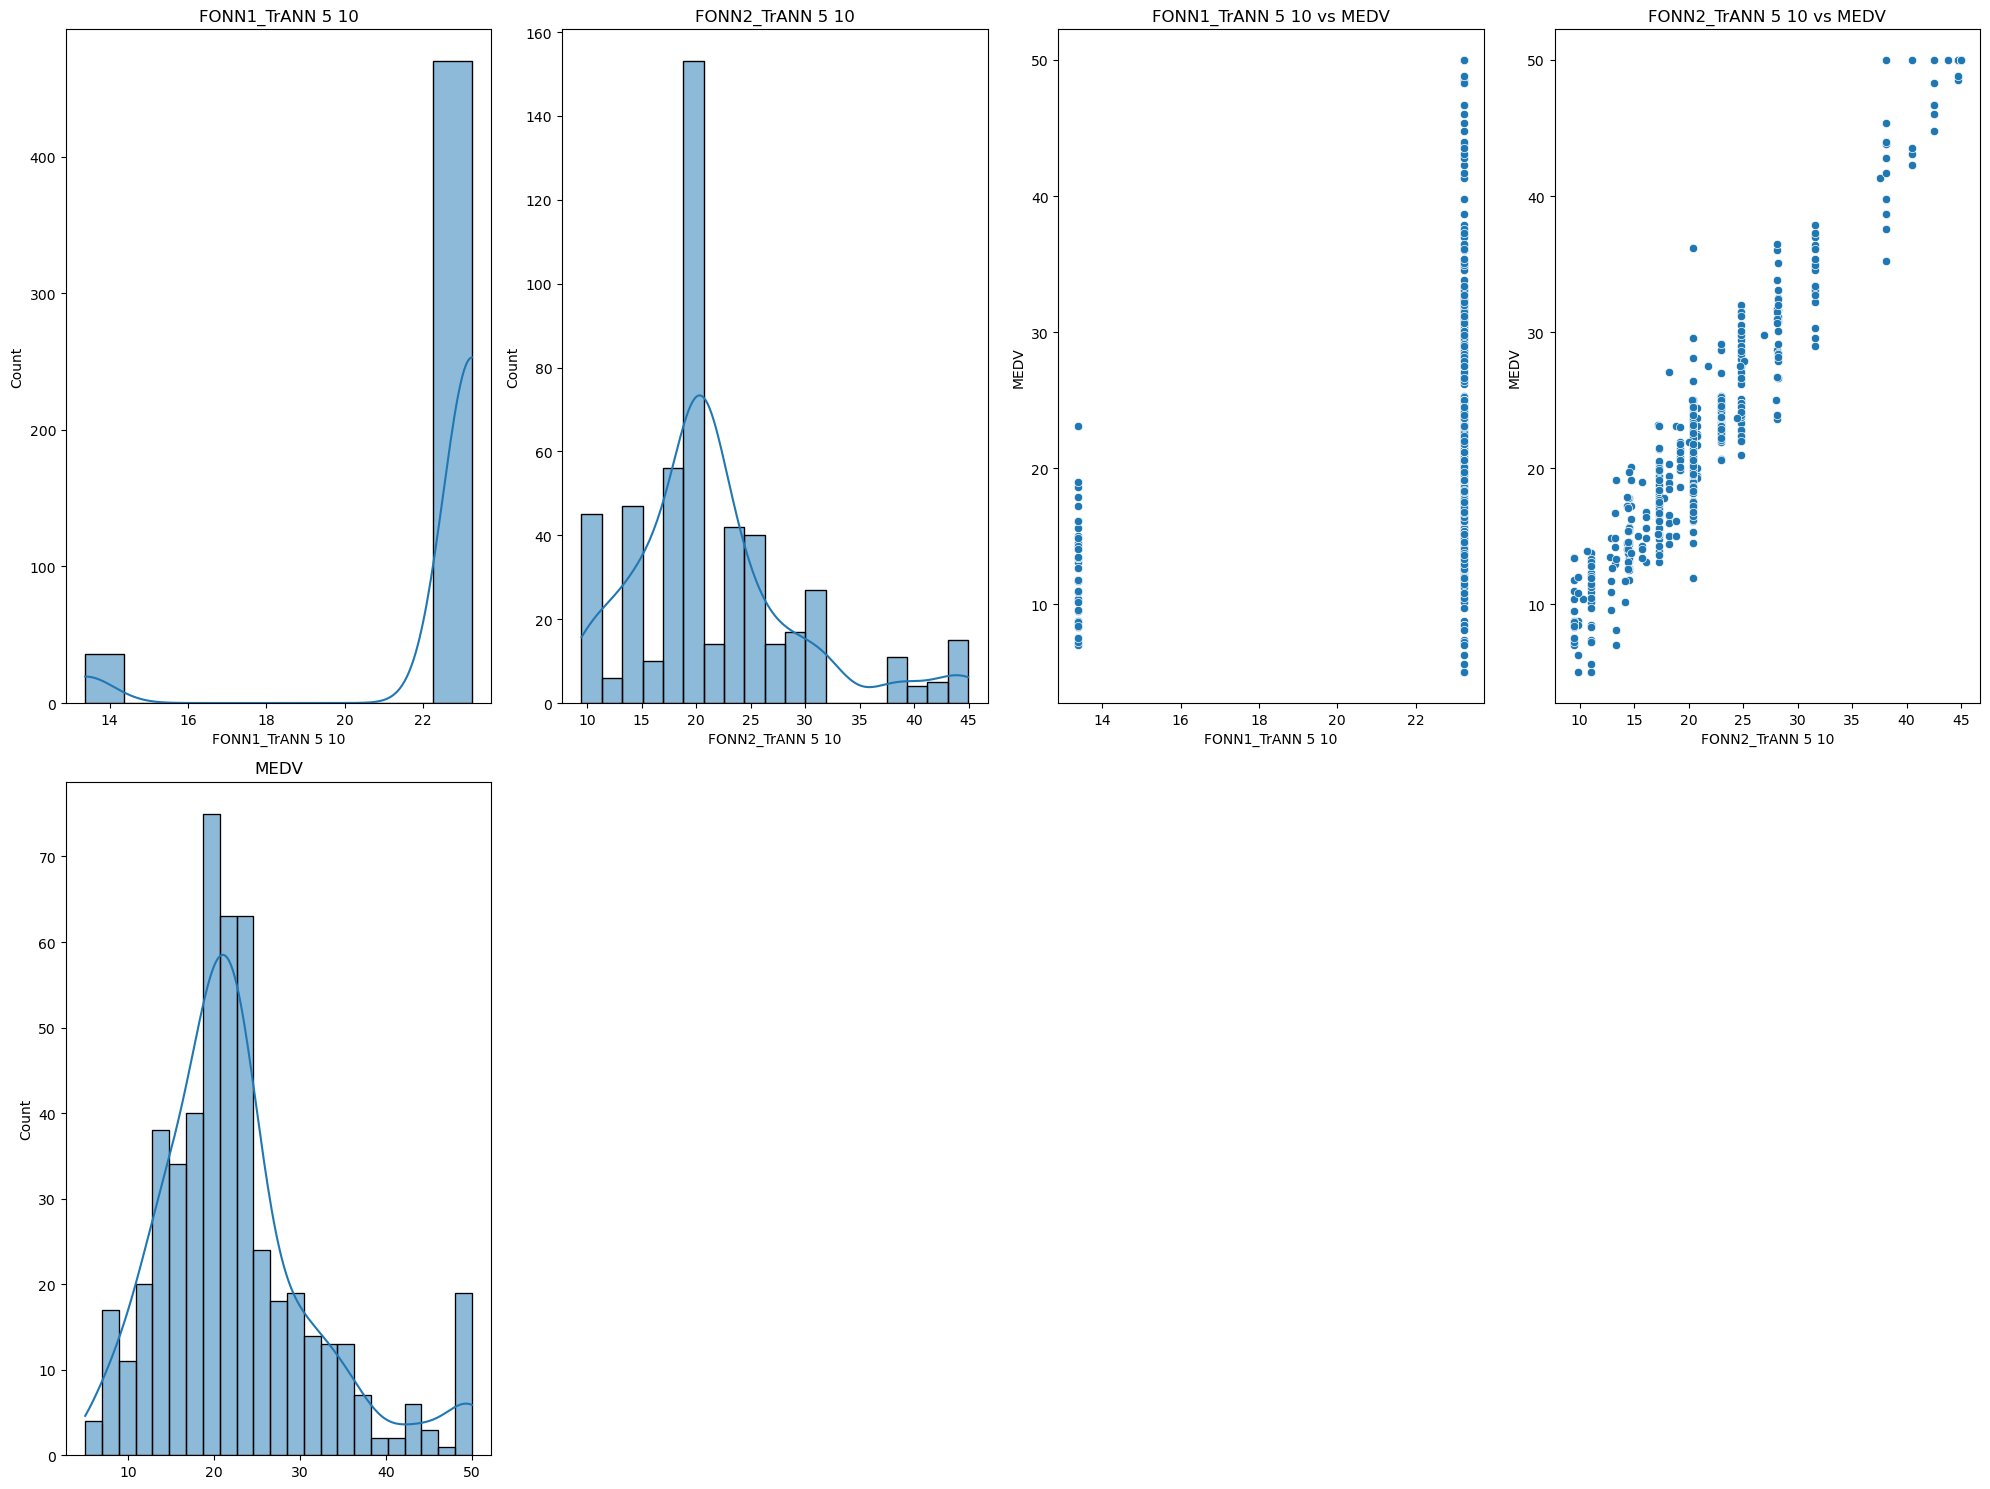

In [ ]:
# Plot Predictions
plot_data(predictions, y)

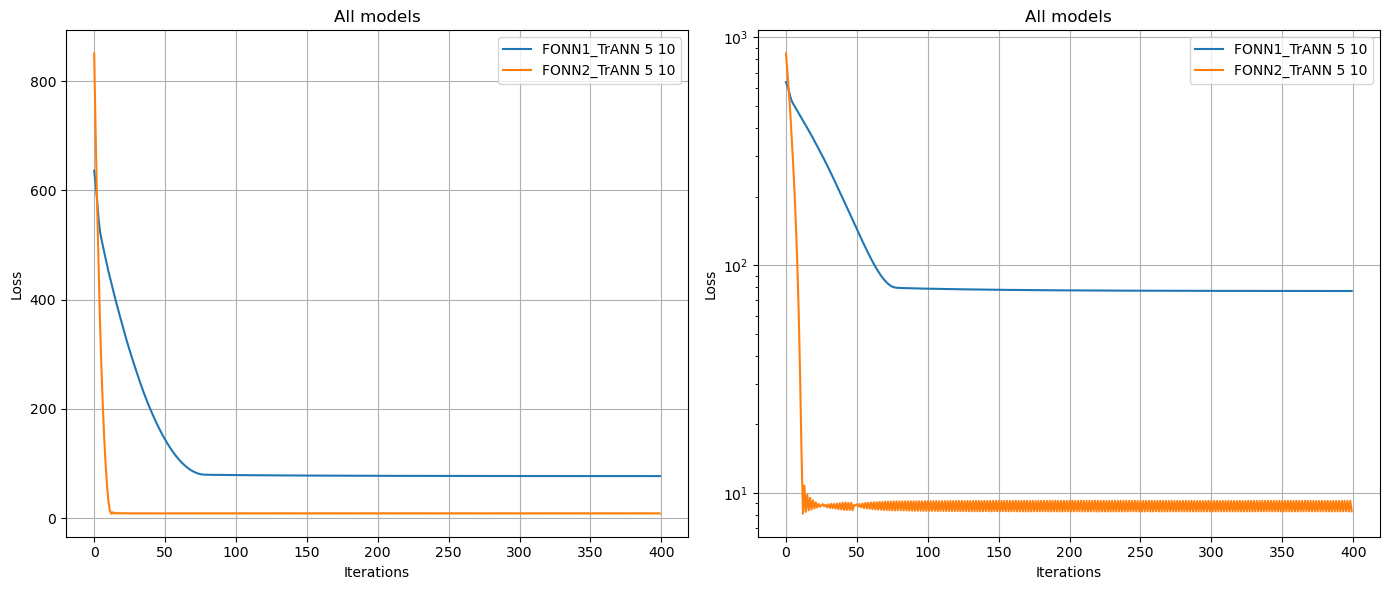

In [ ]:
# Plot all models

def plot_loss(model, ax1, ax2, label):
    ax1.plot(model.loss_curve_, label=label)
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    ax2.plot(model.loss_curve_, label=label)
    ax2.set_yscale("log")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss")
    ax2.grid(True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for model_name, model in models.items():
    if hasattr(model.best_estimator_["model"], "loss_curve_"):
        plot_loss(model.best_estimator_["model"], ax1, ax2, label=model_name)

ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.set_title("All models")
ax1.legend()
ax1.grid(True)

ax2.set_yscale("log")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.set_title("All models")
ax2.legend()
ax2.grid(True)

fig.tight_layout()
fig.show()

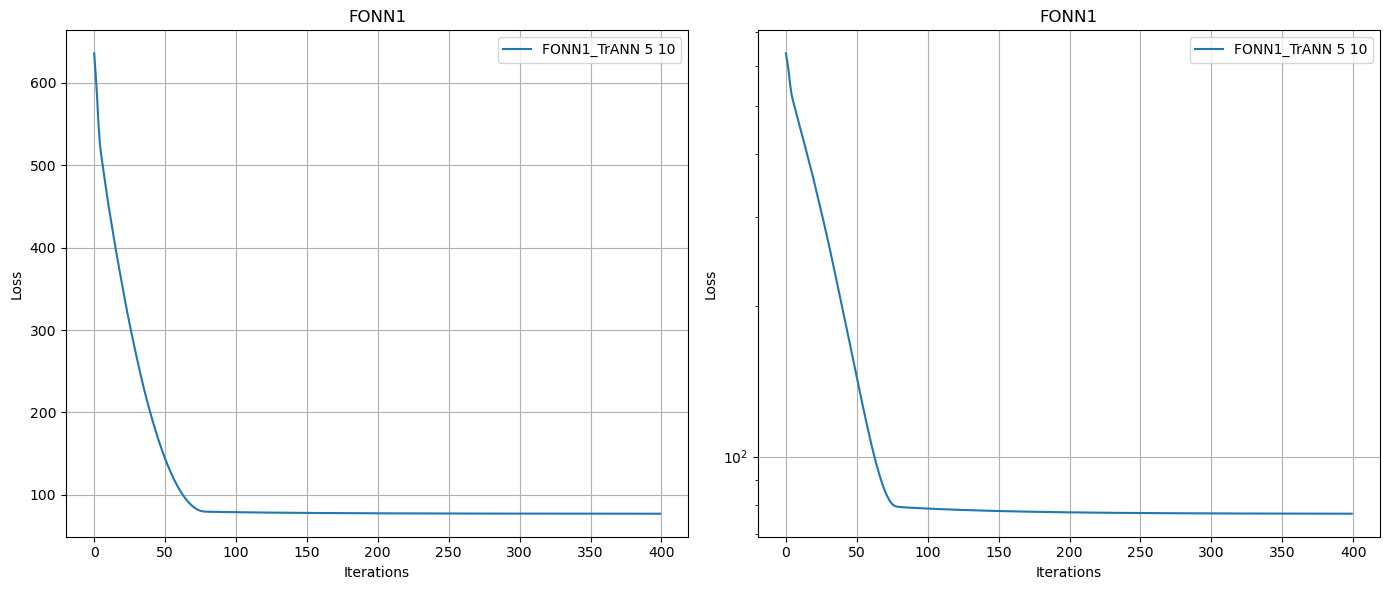

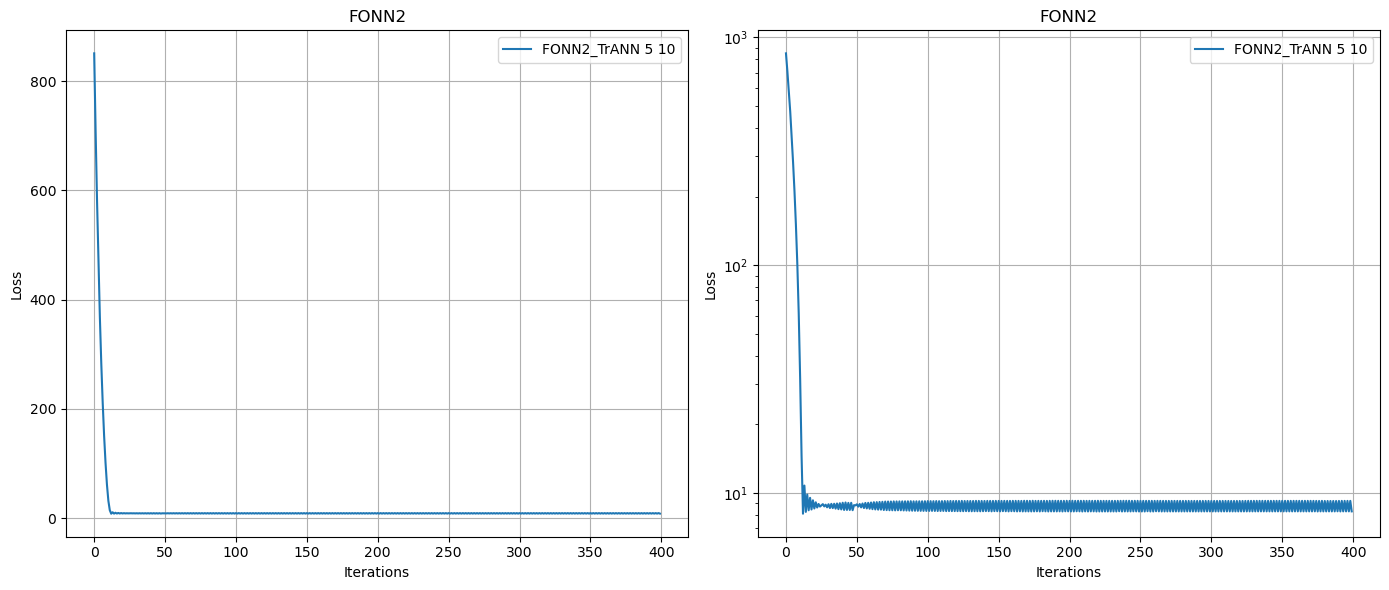

In [ ]:
# Plot model groups

plot_groups = {}
for model_name, model in models.items():
    if hasattr(model.best_estimator_["model"], "loss_curve_"):
        key = model_name.split("_" if "_" in model_name else " ")[0]
        if key not in plot_groups:
            plot_groups[key] = plt.subplots(1, 2, figsize=(14, 6))
        fig, (ax1, ax2) = plot_groups[key]
        plot_loss(model.best_estimator_["model"], ax1, ax2, model_name)

for group, plot in plot_groups.items():
    fig, (ax1, ax2) = plot
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.set_title(group)
    ax1.legend()
    ax1.grid(True)

    ax2.set_yscale("log")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss")
    ax2.set_title(group)
    ax2.legend()
    ax2.grid(True)

    fig.tight_layout()
    fig.show()

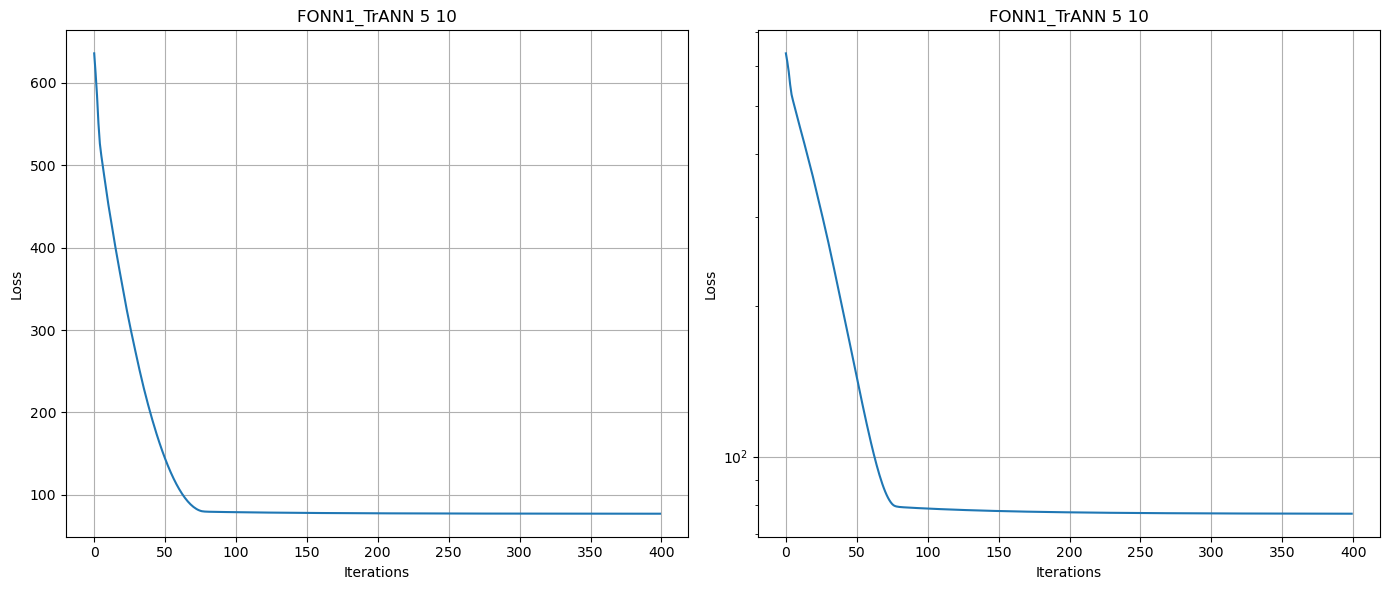

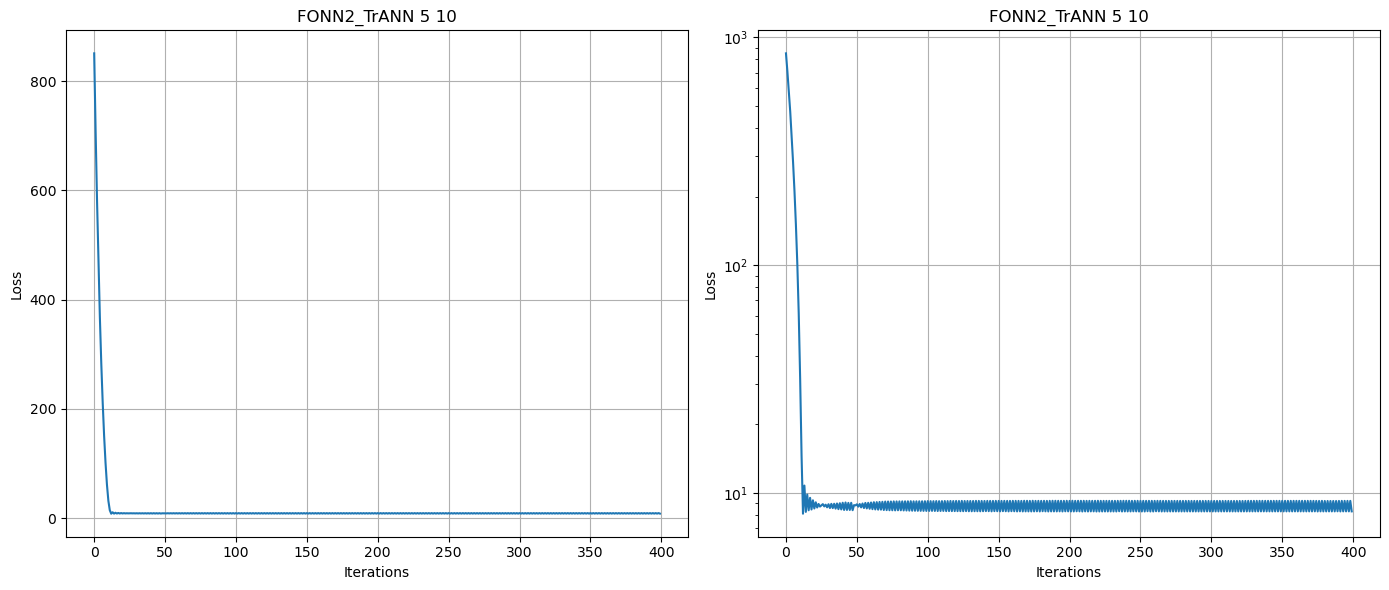

In [ ]:
# Plot individual models

for model_name, model in models.items():
    if hasattr(model.best_estimator_["model"], "loss_curve_"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        plot_loss(model.best_estimator_["model"], ax1, ax2, model_name)
        ax1.set_title(model_name)
        ax2.set_title(model_name)
        fig.tight_layout()
        fig.show()